In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np


In [2]:
df = pd.read_csv("../data/data_sum.csv")

In [3]:
df.shape

(13497, 3)

In [4]:
df.head

<bound method NDFrame.head of        ir_L  ir_R  degree
0       0.0   0.0    0.00
1       2.8  15.1   55.42
2       2.8  15.2   55.42
3       2.6  15.4   55.40
4       2.6  15.6   52.00
...     ...   ...     ...
13492   2.6  12.1   51.49
13493   2.6  12.0   51.47
13494   2.6  12.2   51.51
13495   2.6  12.2   51.49
13496   2.5  12.2   51.47

[13497 rows x 3 columns]>

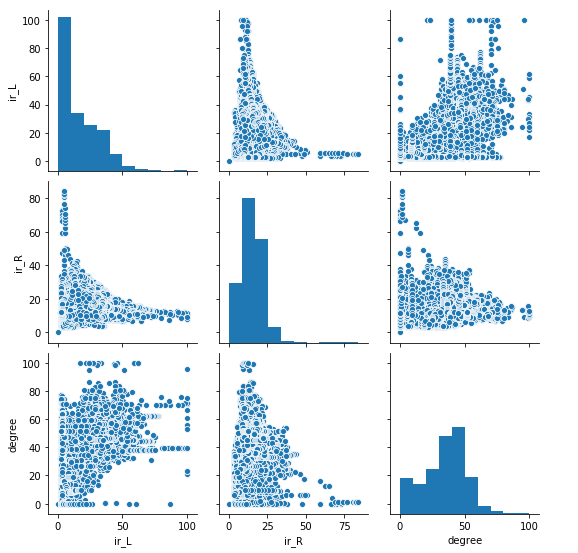

In [5]:
sns.pairplot(df, diag_kind='hist')

plt.show()

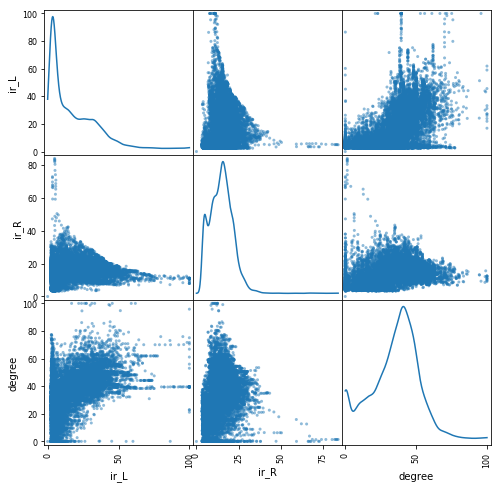

In [6]:
scatter_matrix(df, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()

# Normalization

In [7]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(df)
df_n = pd.DataFrame(scaler.transform(df),columns=['ir_L', 'ir_R', 'degree'])

In [8]:
df_n

,ir_L,ir_R,degree
0,0.000,0.000000,0.0000
1,0.028,0.179762,0.5542
2,0.028,0.180952,0.5542
3,0.026,0.183333,0.5540
4,0.026,0.185714,0.5200
...,...,...,...
13492,0.026,0.144048,0.5149
13493,0.026,0.142857,0.5147
13494,0.026,0.145238,0.5151
13495,0.026,0.145238,0.5149


# Split data

In [10]:
# Original Data
# df_inputs = df.loc[:,['ir_L', 'ir_R']]
# df_outputs = df.loc[:,['degree']]

# Normalized Data
df_inputs = df_n.loc[:,['ir_L', 'ir_R']]
df_outputs = df_n.loc[:,['degree']]

inputs = np.array(df_inputs)
outputs = np.array(df_outputs)

In [11]:
num_data = len(inputs)
TRAIN_SPLIT = int(0.6 * num_data)
TEST_SPLIT = int(0.2 * num_data + TRAIN_SPLIT)

In [12]:
inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

# Multiple Linear Regression

In [13]:
from sklearn.linear_model import LinearRegression
mlr = LinearRegression()
mlr.fit(inputs_train, outputs_train)

LinearRegression()

In [14]:
# The coefficients
print('Coefficients: \n', mlr.coef_)

# mean square error
print("RSS: %.2f" % np.mean((mlr.predict(inputs_test) - outputs_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % mlr.score(inputs_test, outputs_test))

Coefficients: 
 [[0.49451996 0.33571261]]
RSS: 0.02
Variance score: 0.32


In [15]:
outputs_predict = mlr.predict(inputs_test)

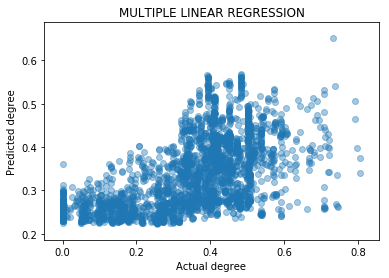

In [16]:
plt.scatter(outputs_test, outputs_predict, alpha=0.4)
plt.xlabel("Actual degree")
plt.ylabel("Predicted degree")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

# DNN

In [17]:
import tensorflow as tf

In [18]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape = inputs_train.shape[1]))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=.2))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=.2))

model.add(tf.keras.layers.Dense(1, activation='relu'))



model.compile(optimizer='adam', loss='mse', metrics=['acc']) # mse / mae
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               300       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 5,401
Trainable params: 5,401
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(inputs_train, outputs_train, epochs=5, batch_size=1, validation_data=(inputs_validate, outputs_validate))

Train on 8098 samples, validate on 2700 samples
Epoch 1/5
8098/8098 [==============================] - 35s 4ms/sample - loss: 0.0203 - acc: 2.4697e-04 - val_loss: 0.0179 - val_acc: 0.0000e+00
Epoch 2/5
8098/8098 [==============================] - 34s 4ms/sample - loss: 0.0184 - acc: 2.4697e-04 - val_loss: 0.0172 - val_acc: 0.0000e+00
Epoch 3/5
8098/8098 [==============================] - 34s 4ms/sample - loss: 0.0182 - acc: 2.4697e-04 - val_loss: 0.0173 - val_acc: 0.0000e+00
Epoch 4/5
8098/8098 [==============================] - 34s 4ms/sample - loss: 0.0180 - acc: 3.7046e-04 - val_loss: 0.0187 - val_acc: 0.0000e+00
Epoch 5/5
8098/8098 [==============================] - 34s 4ms/sample - loss: 0.0178 - acc: 2.4697e-04 - val_loss: 0.0171 - val_acc: 0.0000e+00


In [20]:
outputs_predict = model.predict(inputs_test)

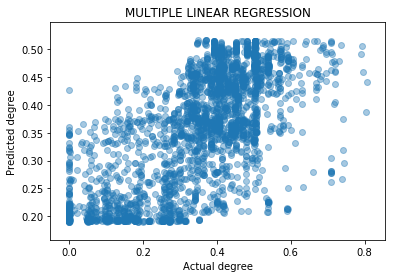

In [21]:
plt.scatter(outputs_test, outputs_predict, alpha=0.4)
plt.xlabel("Actual degree")
plt.ylabel("Predicted degree")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

# Feature 추가(mot_L, mot_R)

In [22]:
def chdeg(degree_original):
    degree = ((degree_original - 50)*1.5)//1
    if degree <= 0:
        left = 25
        right = 25 + abs(degree)
    else:
        left = 25 - abs(degree)
        right = 25
    return left, right

left = []
right = []
for i in range(len(df)):
    left.append(chdeg(df['degree'][i])[0])
    right.append(chdeg(df['degree'][i])[1])
    
df['mot_L'] = left
df['mot_R'] = right

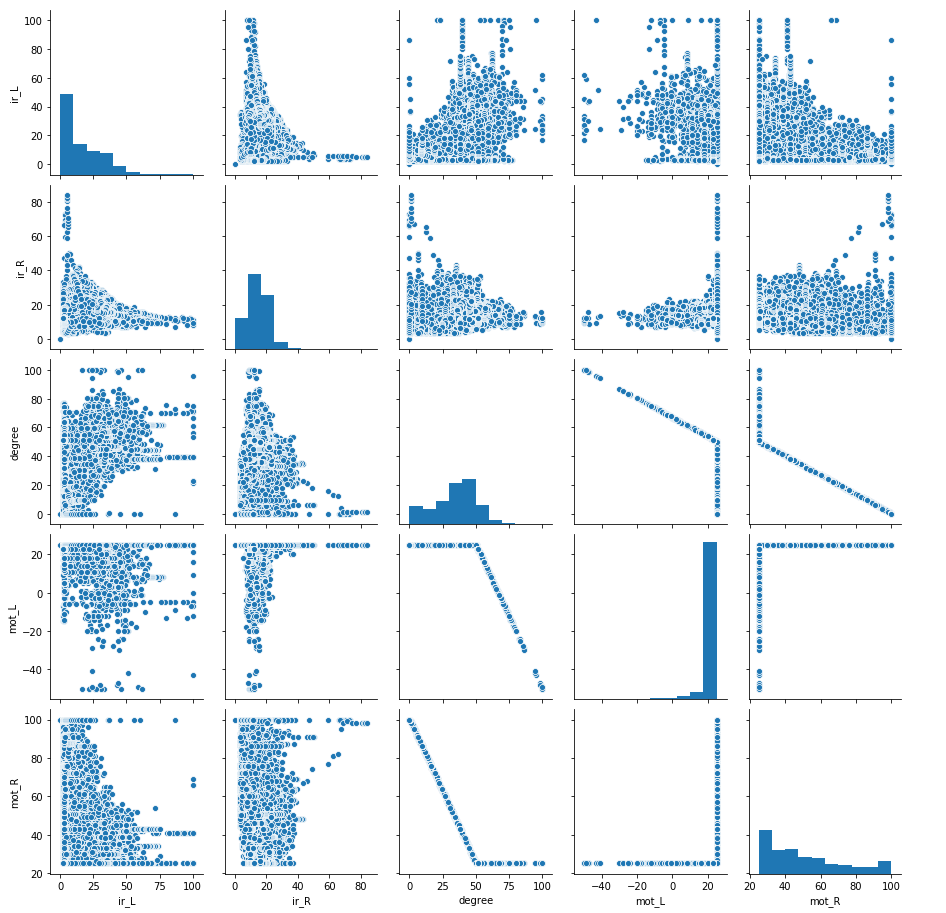

In [23]:
sns.pairplot(df, diag_kind='hist')

plt.show()

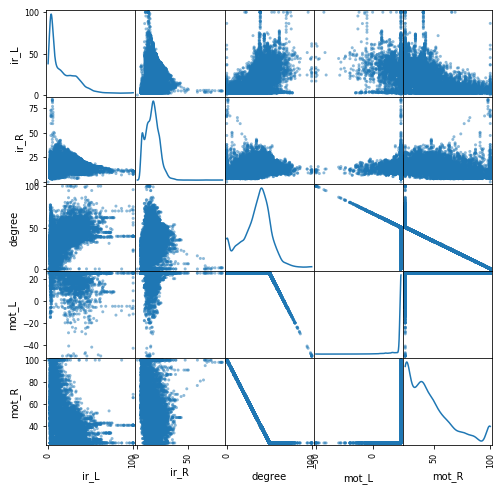

In [24]:
scatter_matrix(df, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()